In [ ]:
# import Libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, ImageEnhance
import os
import cv2
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Explore Data

In [ ]:
df =  pd.read_csv("/content/styles.csv",on_bad_lines="skip")

In [ ]:
df.sort_values("id",inplace=True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
12894,1163,Men,Apparel,Topwear,Tshirts,Blue,Summer,2011.0,Sports,Nike Sahara Team India Fanwear Round Neck Jersey
12617,1164,Men,Apparel,Topwear,Tshirts,Blue,Winter,2015.0,Sports,Nike Men Blue T20 Indian Cricket Jersey
16344,1165,Men,Apparel,Topwear,Tshirts,Blue,Summer,2013.0,Sports,Nike Mean Team India Cricket Jersey
9203,1525,Unisex,Accessories,Bags,Backpacks,Navy Blue,Fall,2010.0,Casual,Puma Deck Navy Blue Backpack
33206,1526,Unisex,Accessories,Bags,Backpacks,Black,Fall,2010.0,Sports,Puma Big Cat Backpack Black


In [ ]:
df.iloc[:4500,:].nunique()

id                    4500
gender                   5
masterCategory           4
subCategory             17
articleType             40
baseColour              25
season                   4
year                    10
usage                    6
productDisplayName    4432
dtype: int64

In [ ]:
la = df.subCategory.reset_index()
la = la["subCategory"]

In [ ]:
la[:4000].value_counts()

subCategory
Topwear             2186
Shoes               1055
Bags                 212
Bottomwear           164
Flip Flops           123
Sandal               117
Watches               46
Headwear              33
Dress                 24
Sports Equipment      17
Water Bottle           5
Socks                  5
Accessories            4
Apparel Set            4
Belts                  4
Innerwear              1
Name: count, dtype: int64

In [ ]:
img = Image.open("/kaggle/input/fashion-product-images-small/images/10001.jpg")
img

np.array(img).shape

(80, 60, 3)

In [ ]:
def load_images(folder_path, img_count=None, target_height=80, target_width=60):
    images = []
    count = 0

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        # Resize the image to a common size
        img = cv2.resize(img, (target_width, target_height))

        images.append(img)
        count += 1

        if img_count and count == img_count:
            break
    return np.array(images)

# Function to flatten and center the image data
def preprocess_data(images):
    num_images, height, width, channel = images.shape
    flattened_data = images.reshape((num_images, height * width * channel))
    mean_vals = np.mean(flattened_data, axis=0)
    centered_data = flattened_data - mean_vals
    return centered_data, mean_vals

In [ ]:
%%time
img_data = load_images("/kaggle/input/fashion-product-images-small/images", img_count=4000)

CPU times: user 1.32 s, sys: 1.14 s, total: 2.45 s
Wall time: 43.7 s


In [ ]:
img_data.shape

(4000, 80, 60, 3)

In [ ]:
centered_data, mean_vals = preprocess_data(img_data)

In [ ]:
mean_vals.shape

(14400,)

In [ ]:
%%time
num_components = 186  # Adjust as needed
pca = PCA(n_components=num_components)
lower_dimensional_data = pca.fit_transform(centered_data)

CPU times: user 35.5 s, sys: 6.14 s, total: 41.6 s
Wall time: 11.4 s


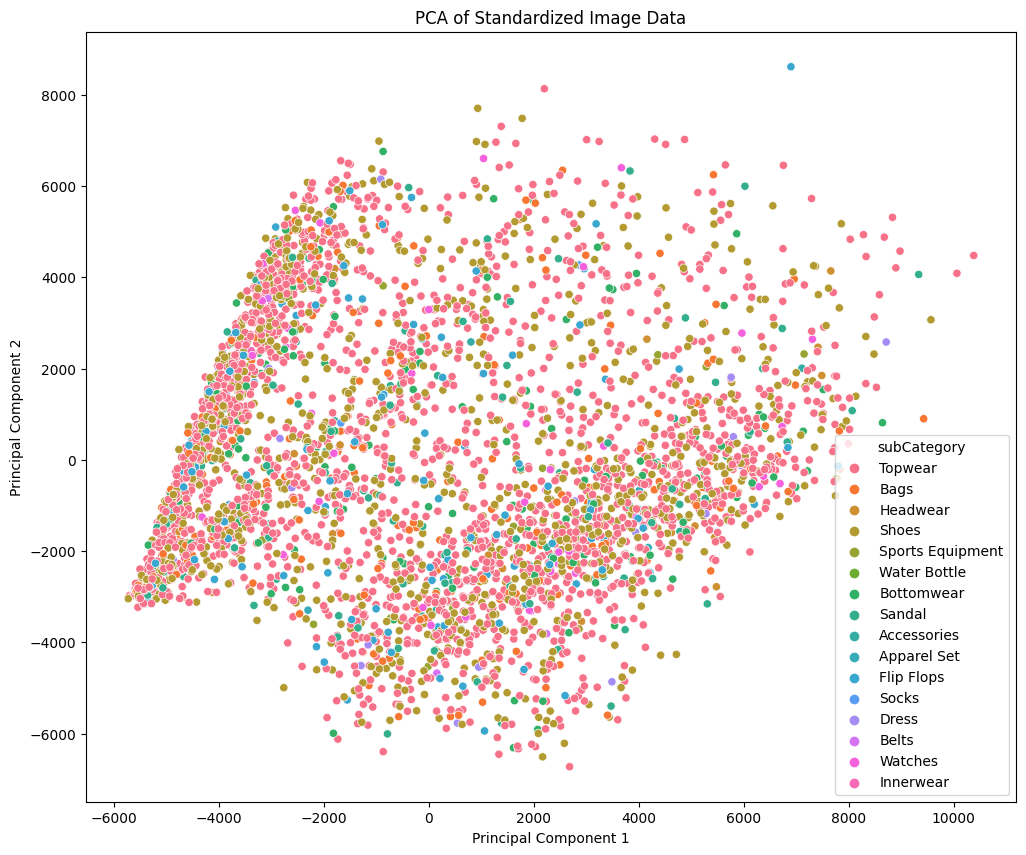

In [ ]:
fig, axes = plt.subplots(figsize=(12, 10))
sns.scatterplot(x=lower_dimensional_data[:, 0], y=lower_dimensional_data[:, 1],hue=la[0:4000] )
plt.title('PCA of Standardized Image Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

from this figure we can observe that we have subcategory Topwear, Bags, Shoes are higher in number since we have

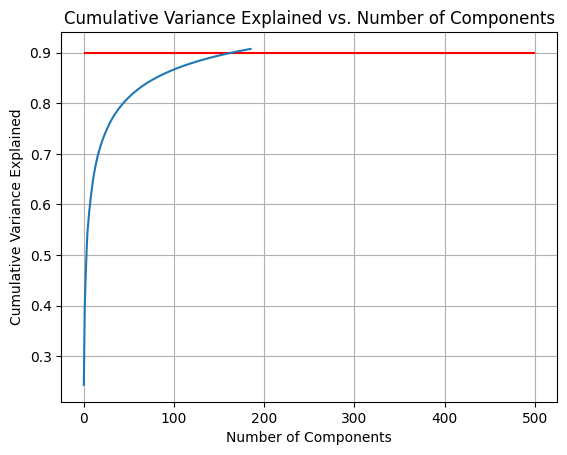

PCA found 90% of data in 165 components


In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
threshold = cumulative_variance[cumulative_variance <= 0.9]
plt.hlines(y=[0.9],xmin=[0],xmax=[500], colors=["red"])
plt.plot(cumulative_variance)
plt.title('Cumulative Variance Explained vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()
print(f"PCA found 90% of data in {len(threshold)} components")

## Reconstruction Loss

In [ ]:
def recon_loss(pca,X):
    X_pca = pca.transform(X)
    X_recon = pca.inverse_transform(X_pca)
    reconstruction_loss = np.mean((X-X_recon)**2,axis=1)
    return reconstruction_loss

In [ ]:
recon_data = pca.inverse_transform(lower_dimensional_data)

### Comparision between Reconstructed image and Original image

In [ ]:
def comparison(idx):
    original = img_data[idx]
    reconstruct_img = recon_data.reshape(4000,80,60,3)[idx]
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Plot the first chart (Cumulative Variance)
    axes[0].imshow(original)
    axes[0].set_title('Original Image')

    # Plot the second chart (Individual Variances)
    axes[1].imshow(reconstruct_img)
    axes[1].set_title('Recontructed Image')
    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

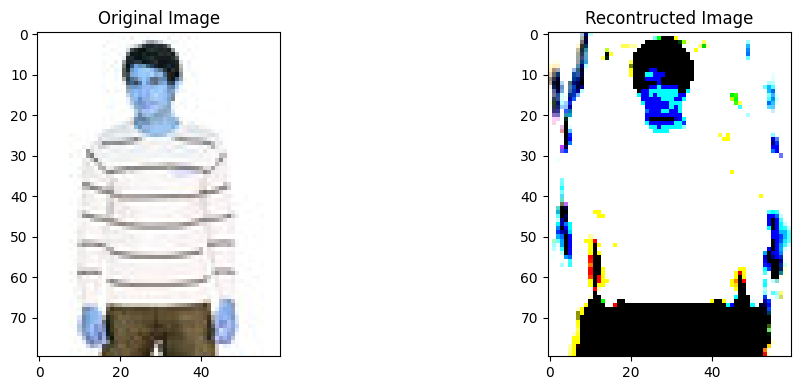

In [ ]:
comparison(5)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, silhouette_score

In [ ]:
k_range = range(8, 17)
inertias = []
k_result = []
silhouette_scores = []
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42, init="k-means++",n_init=10)
    model.fit(recon_data)
    labels = model.predict(recon_data)
    silhouette_score_ = silhouette_score(recon_data, labels)
    silhouette_scores.append(silhouette_score_)
    inertias.append(model.inertia_)
    k_result.append(labels)

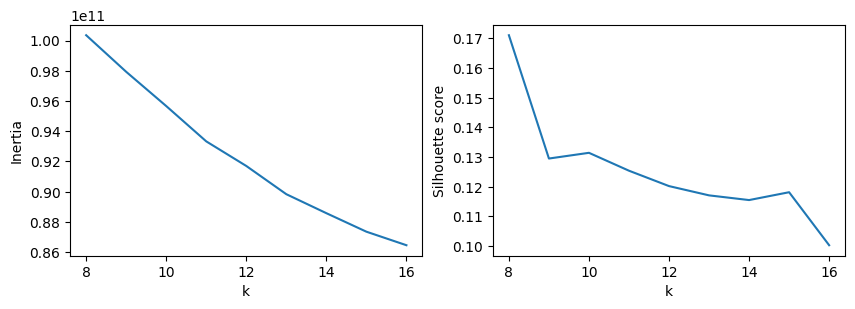

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 3)
axs[0].plot(k_range, inertias)
axs[0].annotate(
    'Elbow', xytext=(7, 10000), xy=(6, inertias[4]),
    arrowprops=dict(arrowstyle="->", color='red'))
axs[1].plot(k_range, silhouette_scores)
axs[0].set(xlabel='k', ylabel='Inertia')
axs[1].set(xlabel='k', ylabel='Silhouette score');

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(recon_data)

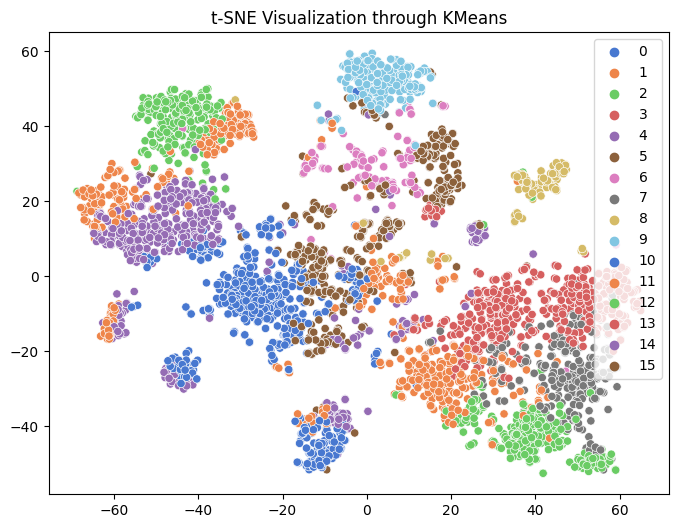

In [ ]:

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x=embedded_data[:, 0], y=embedded_data[:, 1], hue=labels, palette="muted")
plt.title('t-SNE Visualization through KMeans')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
embedded_data_original = tsne.fit_transform(centered_data)


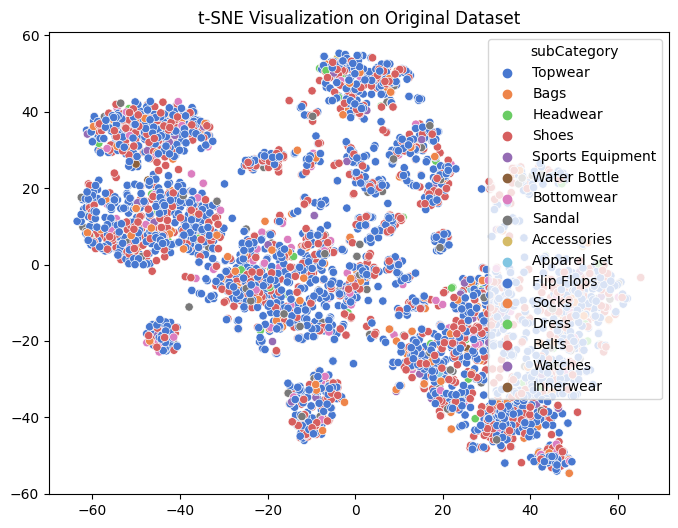

In [ ]:

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x=embedded_data_original[:, 0],  y=embedded_data_original[:, 1], hue=la[0:4000], palette="muted")
plt.title('t-SNE Visualization on Original Dataset')
plt.show()

In [ ]:
import joblib
joblib.dump(model, "model.pkl")

['model.pkl']

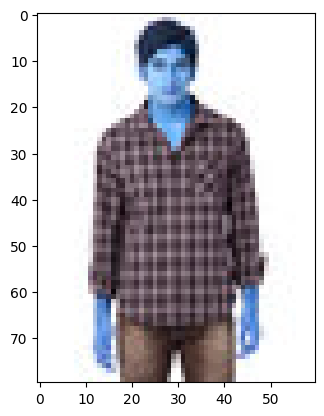

In [ ]:
img = cv2.imread('/kaggle/input/fashion-product-images-small/images/10367.jpg')
plt.imshow(img)

In [ ]:
def load_and_processed_image(img_path,target_height=80, target_width=60):
    img = cv2.imread(img_path)
    img = cv2.resize(img,(target_width, target_height))
    return img.flatten()

In [ ]:
inp_img = load_and_processed_image('/kaggle/input/fashion-product-images-small/images/10367.jpg')
emb_img = pca.transform([inp_img])
rec_img = pca.inverse_transform(emb_img)

In [ ]:
label = model.predict(rec_img)

In [ ]:
label

array([10], dtype=int32)

In [ ]:
matching_indices = np.where(labels == label)[0]

In [ ]:
matching_indices

array([   8,   10,   42,   46,   49,   64,   86,   89,   93,   95,   98,
        119,  125,  138,  145,  154,  156,  158,  159,  161,  162,  164,
        186,  189,  230,  238,  243,  252,  257,  266,  270,  291,  298,
        304,  307,  314,  320,  327,  328,  345,  356,  362,  364,  380,
        391,  396,  398,  399,  405,  407,  408,  413,  439,  440,  461,
        469,  471,  472,  479,  486,  489,  524,  525,  527,  532,  538,
        542,  547,  557,  562,  581,  589,  595,  620,  625,  638,  651,
        659,  667,  670,  673,  683,  688,  691,  697,  698,  710,  716,
        721,  726,  752,  767,  778,  784,  805,  818,  824,  833,  839,
        844,  854,  857,  862,  865,  867,  886,  890,  896,  915,  922,
        930,  931,  934,  953,  965,  985,  986,  993,  994,  998, 1000,
       1003, 1017, 1033, 1053, 1054, 1055, 1057, 1068, 1069, 1071, 1073,
       1075, 1080, 1084, 1087, 1092, 1112, 1126, 1129, 1135, 1137, 1144,
       1154, 1159, 1165, 1168, 1175, 1210, 1223, 12

In [ ]:
def manhattan_distance(image1, image2):
    difference = image1 - image2
    distance = np.sum(np.abs(difference))
    return distance

from scipy.spatial.distance import cityblock
dist = cityblock(rec_img[0], recon_data[122])
dist

2781491.626448373

In [ ]:
labels == label
ls = {}
for i, images in enumerate(recon_data):
        ls[i] = manhattan_distance(rec_img[0],recon_data[i])

In [ ]:
# Sorting the dictionary by values
sorted_dict = dict(sorted(ls.items(), key=lambda item: item[1]))

In [ ]:
sorted_dict

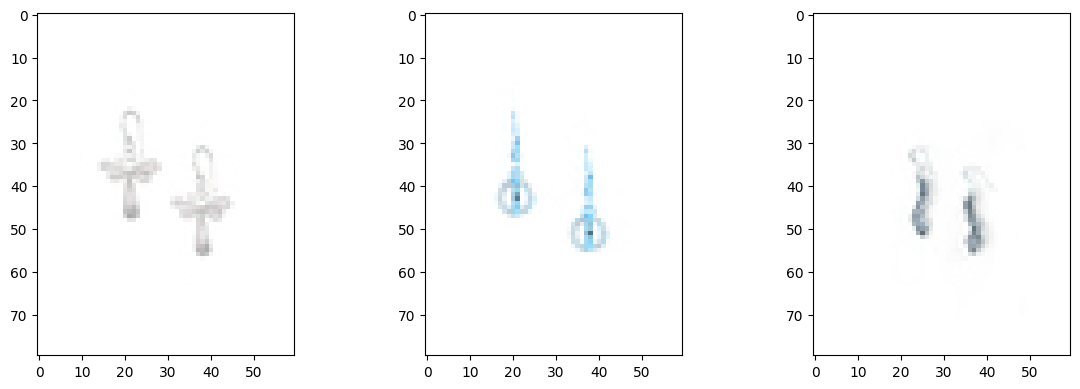

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
count = 0
for i in sorted_dict.keys():
    if count == 3:
        break
    else:
        img_ot = df.iloc[i,0]
        axes[count].imshow(img_data[i])
    count += 1
plt.tight_layout()